## inverse depth map
The inverse depth map is saved in sfront.txt
Note that during training, we use 1/sfront for better performance

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt

D:/sim-data/water-tank/water-tank/brick6\sfront1.txt
(32, 128)


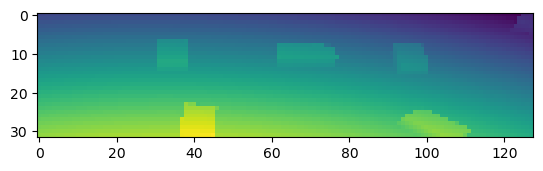

In [19]:
root = 'D:/sim-data/water-tank/water-tank/brick6'
name = 'sfront1.txt'
path = os.path.join(root,name)
print(path)
front = np.loadtxt(path)
print(front.shape)
plt.figure()
plt.imshow(front)

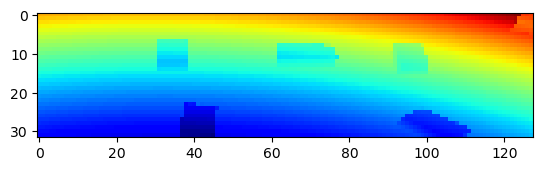

In [20]:
plt.figure()
plt.imshow(1/front,cmap=plt.cm.jet)

In [ ]:
import matplotlib.colors

def make_image(data, outputname,min_bar,max_bar, size=(4, 1), dpi=2000):
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.set_cmap('jet')
    norm = matplotlib.colors.Normalize(vmin=min_bar,vmax=max_bar)
    ax.imshow(data, aspect='equal',norm=norm)
    #ax.set_clim(0,512)
    plt.savefig(outputname, dpi=dpi)
    plt.close(fig)

In [ ]:
def make_image_gray(data, outputname, size=(1, 4), dpi=2000):
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.set_cmap('gray')
    ax.imshow(data, aspect='equal')
    plt.savefig(outputname, dpi=dpi)
    plt.close(fig)

## transfer inverse depth map to point cloud

In [22]:
import torch

# transfer inverse depth map to point cloud
def deth2pc(front,i):
    # front: inverse of depth map in numpy array [32,128]
    # i: number
    y = 1/front

    pc1 = torch.zeros([512, 32, 128], dtype=torch.float32)
    
    r1 = (y-2.0)/(0.003)   # 2.0: minimum range, 0.003: resolution
    r1 = r1.astype(dtype = np.int64)
    r1[r1<0]=0
    r1[r1>511]=0
    
    r1 = r1.astype(dtype = np.int64)
    
    
    for m in range(32):
        for j in range(128):
            if r1[m][j]>0:
                k = r1[m][j]
                pc1[k][m][j] = 1
    data = torch.nonzero(pc1).numpy()
    
    
    r1=2.0+data[:,0]*(0.003)
    phi=np.deg2rad(-7+data[:,1]/32*14)  # 14: aperture angle in elevation
    theta=np.deg2rad(-16+data[:,2]/128*32) # 32: aperture angle in azimurh
    
    length = len(data[:,0])
    
    euc_pc1 = np.zeros([length,3], dtype=np.float32)
    
    euc_pc1[:,0]=r1*np.cos(theta)*np.cos(phi)
    euc_pc1[:,1]=r1*np.sin(theta)*np.cos(phi)
    euc_pc1[:,2]=r1*np.sin(phi)
    
    path = './pc/test'+str(i)+'.txt'
    np.savetxt(path,euc_pc1)

## Chamfer distance

### https://github.com/ThibaultGROUEIX/ChamferDistancePytorch

In [ ]:
import torch, time
import ChamferDistancePytorch.chamfer_python

In [ ]:
list = []
for i in range(299):
    P = np.loadtxt("./result_real/mvs/gt"+str(i)+".txt")
    Q = np.loadtxt("./result_real/mvs/test"+str(i)+".txt")
    
    P = torch.tensor(P)
    Q = torch.tensor(Q)
    
    mydist1, mydist2, myidx1, myidx2 = ChamferDistancePytorch.chamfer_python.distChamfer(P.unsqueeze(0), Q.unsqueeze(0))
    
    dist = mydist1.mean()*500+mydist2.mean()*500
    list.append(dist)

## MAE

In [ ]:
## depth: estimated depth map, depth_gt: ground truth of depth map
mae_list.append(np.mean(np.abs(depth-depth_gt)))
print(np.mean(mae_list))